In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch_geometric.data import DataLoader
from RL_anticipatory.utils import load_model, torch_load_cpu, to_numpy
from RL_anticipatory.problems import problem_anticipatory
from MixedIntegerOptimization.offlineOptimizationProblem_TimeWindow_rl import runMaxFlowOpt, plotResults
from UtilsCode.createGif import create_gif
import time
import os

In [2]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map
    """
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    return plt.cm.get_cmap(base_cmap, N)

In [3]:
def plot_one_vehicle_route(route, ax1, cmap):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    """
    depot_marker = '*'
    regular_marker = 's'
    for j in range(route.shape[0]):
        if j == 0:
            marker = depot_marker
        else:
            marker = regular_marker
            ax1.plot([route[j-1, 0], route[j, 0]], [route[j-1, 1], route[j, 1]], color=cmap)
        # ax1.text(route[j, 0], route[j, 1], str(j))
        # ax1.scatter(route[j, 0], route[j, 1], color=cmap, marker=marker)

In [4]:
def plot_events(events_loc, ax1):
    for j in range(events_loc.shape[0]):
        ax1.scatter(events_loc[j, 0], events_loc[j, 1], color='r', marker='o')
        ax1.text(events_loc[j, 0], events_loc[j, 1], str(j))

In [5]:
def plot_all_vehicles_and_events(network_name, ax, fig, all_events_loc, cars_route):
    # Plot the results
        fig_title = network_name
        for i, (events, routes) in enumerate(zip(all_events_loc.values(), cars_route)):
            x_p = i // 2
            y_p = i % 2
            for i_c in range(args['n_cars']):
                route = routes[i_c, ...]
                plot_one_vehicle_route(route, ax[x_p][y_p], cmap_v(i_c))
            plot_events(to_numpy(events), ax[x_p][y_p])
            ax[x_p][y_p].grid()
        fig.suptitle(fig_title, fontsize=16)

In [6]:
def plot_current_time_anticipatory(cur_time, cars_loc, events_loc, events_time, events_answered_time, nc, ne, gs, fileName):
    fig, ax = plt.subplots()
    ax.set_title('time: {0}'.format(cur_time))
    for c in range(nc):
        ax.scatter(cars_loc[c, 0], cars_loc[c, 1], c='k', alpha=1, marker='s')
    ax.scatter([], [], c='y', label='Future Requests')
    ax.scatter([], [], c='b', label='Opened')
    # ax.scatter([], [], c='b', label='Opened commited')
    ax.scatter([], [], c='r', label='Canceled')
    ax.scatter([], [], c='g', label='Closed')
    for i in range(ne):
        if events_answered_time[i] < cur_time:
            ax.scatter(events_loc[i, 0], events_loc[i, 1], c='g', alpha=0.7, marker='o', s=40)
        elif (events_time[i, 0] < cur_time) and (events_time[i, 1] > cur_time) and (cur_time < events_answered_time[i]):
            ax.scatter(events_loc[i, 0], events_loc[i, 1], c='b', alpha=0.7, marker='o', s=40)
        elif events_time[i, 0] > cur_time:
            ax.scatter(events_loc[i, 0], events_loc[i, 1], c='y', alpha=0.7, marker='o', s=40)
        elif events_time[i, 1] < cur_time:
            ax.scatter(events_loc[i, 0], events_loc[i, 1], c='r', alpha=0.7, marker='o', s=40)
        else:
            ax.scatter(events_loc[i, 0], events_loc[i, 1], c='b', alpha=0.7, marker='o', s=40)
    ax.set_xlim([-1, gs + 1])
    ax.set_ylim([-1, gs + 1])
    ax.grid(True)
    plt.legend()
    plt.savefig(fileName + '_' + str(cur_time) + '.png')
    plt.close()
    return

In [7]:
def create_gif_figures(network_name, fig_save_loc, all_events_time, all_events_loc, all_events_answer_time, car_routes, total_sim_time):
    if not os.path.exists(fig_save_loc + network_name):
        os.makedirs(fig_save_loc + network_name)
    for i, (events_time, events_loc, routes) in enumerate(zip(all_events_time.values(), all_events_loc.values(), cars_routes)):
        fig_name = 'gif'+'_'+str(i)
        n_events = events_loc.shape[0]
        for t in range(total_sim_time):
            events_answered_time = all_events_answer_time[i, ...]
            plot_current_time_anticipatory(t, routes[:, t, :], events_loc, events_time, events_answered_time,
                                           args['n_cars'], n_events, gs, fig_save_loc + network_name + '/' + fig_name)
        list_names = [fig_name + '_' + str(t) + '.png' for t in range(total_sim_time)]
        create_gif(fig_save_loc + network_name + '/', list_names, 1, fig_name)
        [os.remove(fig_save_loc + network_name + '/' + f) for f in list_names]

In [8]:
def post_analysis_model(state):
    data_out = {}
    n_events = state.n_events
    n_samples = state.batch_size
    n_events_created = np.zeros([n_samples, state.sim_length])
    n_events_answered = np.zeros([n_samples, state.sim_length])
    data_out['all_events_loc'] = state.events_loc_dict
    data_out['all_events_time'] = state.events_time_dict
    data_out['cars_routes'] = to_numpy(state.cars_route)
    data_out['all_events_answer_time'] = to_numpy(state.events_answer_time)
    data_out['n_events_closed'] = to_numpy(state.n_events_closed)
#     for i in range(state.sim_length):
#         n_events_created[:, i] = np.sum(data_out['all_events_time'][:, 0]<=i)
    return data_out

In [9]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
network_path = 'outputs/anticipatory_rl_7/'
fig_save_loc = 'figures/'
network_names = []
n_samples = 40
sim_length = 15
flag_plot_results = False
flag_create_gif = False
run_optimal_results = True
# network_names.append('anti_with_time_window_20200317T094536/epoch-2741

# mtsp cases:

network_names.append('mtsp_20200326T235650/epoch-2')
# network_names.append('mtsp_20200327T134224/epoch-2497')
network_names.append('mtsp_20200329T000930/epoch-2566')
# network_names.append('mtsp_20200329T000930/epoch-2652')

# anticipatory cases:
# network_names.append('anti_with_time_window_20200329T000906/epoch-2530')


In [10]:
cmap = discrete_cmap(len(network_names)+1)
n_splots = int(np.ceil(n_samples / 2))
n_networks = len(network_names)
total_cost_all_nets = np.zeros([n_networks, n_samples])
for i_n, network_name in enumerate(network_names):
    if flag_plot_results:
        fig, ax = plt.subplots(n_splots, 2)
    model, args, sim_input_dict, stochastic_input_dict = load_model(network_path + network_name + '.pt', 'anticipatory')
    args['no_cuda'] = False
    args['use_cuda'] = torch.cuda.is_available() and not args['no_cuda']
    args['device'] = torch.device("cuda:0" if args['use_cuda'] else "cpu")
    gs = args['graph_size']
#     model.sim_input_dict['sim_length'] = sim_length
    model.stochastic_input_dict['should_calc_anticipatory'] = False
    model.sim_input_dict['is_training'] = False
    # model.sim_input_dict['print_debug'] = True
    load_data = torch_load_cpu(network_path+network_name + '.pt')
    if i_n == 0:
        cmap_v = discrete_cmap(args['n_cars']+10)
        dataset = problem_anticipatory.AnticipatoryDataset("", args['n_cars'], args['n_events'], args['events_time_window'],
                                                           sim_input_dict['sim_length'], args['graph_size'],
                                                           args['cancel_cost'], args['close_reward'],
                                                           args['movement_cost'], args['open_cost'],
                                                           args['lam'], args['device'], n_samples)
        dataloader = DataLoader(dataset, batch_size=1000)
        batch_data = next(iter(dataloader))
        n_events_closed = np.zeros([n_networks, n_samples, sim_input_dict['sim_length']])
    with torch.no_grad():
        model = model.to(args['device'])
        t_start = time.time()
        _, _, actions_chosen, logits_chosen, cost_chosen, state = model(batch_data)
        t_end = time.time()
    data_out = post_analysis_model(state)
    all_events_loc = data_out['all_events_loc']
    all_events_time = data_out['all_events_time']
    all_events_answer_time = data_out['all_events_answer_time']
    cars_routes = data_out['cars_routes']
    n_events_closed[i_n, ...] = data_out['n_events_closed']
    total_sim_time = sim_input_dict['sim_length']
    total_cost = torch.sum(cost_chosen, dim=1)
    mean_cost = torch.mean(total_cost)
    std_cost = torch.std(total_cost)
    total_cost_all_nets[i_n, :] = to_numpy(total_cost)
    if flag_plot_results:
        plot_all_vehicles_and_events(network_name, ax, fig, all_events_loc, cars_routes)
    if flag_create_gif:
        create_gif_figures(network_name, fig_save_loc, all_events_time, all_events_loc, all_events_answer_time, cars_routes, total_sim_time)
    print("****************************************************************")
    print("network  - "+network_name)
    print("total run time for " + str(n_samples) + ", is:" + str(t_end - t_start))
    print("mean cost for net:"+str(to_numpy(mean_cost))+", -+ std:"+str(to_numpy(std_cost)))
    total_num_closed = to_numpy(state.events_status['answered'].sum(1).view(-1))
    print("num  events closed:" + str(total_num_closed))
    print("mean num events closed:" + str(np.mean(total_num_closed)))
if run_optimal_results:
    opt_cost = np.zeros(n_samples)
    n_events_closed_opt = np.zeros(n_samples)
    cars_loc = to_numpy(state.cars_route)[:, :, 0, :]
    all_events_loc = state.events_loc_dict
    all_events_time = state.events_time_dict
    close_reward  = args['close_reward']
    cancel_penalty = args['cancel_cost']
    open_penalty = args['open_cost']
    movement_penalty = args['movement_cost']
    t_start_opt = time.time()
    for i_b in range(n_samples):
        if to_numpy(all_events_time[i_b])[:, 0].size > 0:
            m, obj = runMaxFlowOpt(sim_length, 0, cars_loc[i_b, ...], to_numpy(all_events_loc[i_b]),
                                   to_numpy(all_events_time[i_b])[:, 0], to_numpy(all_events_time[i_b])[:, 1],
                                   close_reward, cancel_penalty, open_penalty, movement_penalty, outputFlag=0)
            opt_cost[i_b] = -obj.getValue()
            dataOut, param, cars_paths = plotResults(m, cars_loc[i_b, ...], to_numpy(all_events_loc[i_b]), to_numpy(all_events_time[i_b])[:, 0],
                                                     to_numpy(all_events_time[i_b])[:, 1], False,
                                                     fig_save_loc, "opt_with_time_window"+str(i_b), args['graph_size'])
            n_events_closed_opt[i_b] = dataOut['closedEvents'][-1]
        else:
            opt_cost[i_b] = 0
            n_events_closed_opt[i_b] = 0
    t_end_opt = time.time()
    print("****************************************************************")
    print("optimization results - ")
    print("total run time for " + str(n_samples) + ", is:" + str(t_end_opt - t_start_opt))
    print("mean cost:"+str(np.mean(opt_cost)) + " -+ std:" +str(np.std(opt_cost)))
    print("optimal cost is:" + str(opt_cost))
    print("num events closed :"+ str(n_events_closed_opt))
    print("mean num events closed:" + str(np.mean(n_events_closed_opt)))

/usr/local/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'RL_anticipatory.nets.RL_Model.AnticipatoryModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch_geometric.nn.conv.gat_conv.GATConv' has changed. you can retrieve the original source code by accessing the object

  [*] Loading model from outputs/anticipatory_rl_7/mtsp_20200326T235650/epoch-2.pt
****************************************************************
network  - mtsp_20200326T235650/epoch-2
total run time for 40, is:10.16205382347107
mean cost for net:2381.25, -+ std:734.99414
num  events closed:[1 1 2 0 0 0 2 0 0 2 0 1 1 3 2 2 0 0 1 2 1 1 1 2 3 0 0 3 3 1 2 2 0 2 0 3 2
 1 0 1]
mean num events closed:1.2
  [*] Loading model from outputs/anticipatory_rl_7/mtsp_20200329T000930/epoch-2566.pt
****************************************************************
network  - mtsp_20200329T000930/epoch-2566
total run time for 40, is:10.257050037384033
mean cost for net:976.25, -+ std:572.1067
num  events closed:[4 3 4 3 1 3 3 4 4 4 4 4 3 4 2 4 3 2 4 4 3 4 4 2 4 3 4 4 4 3 4 4 4 4 3 3 4
 4 4 4]
mean num events closed:3.5
Academic license - for non-commercial use only
****************************************************************
optimization results - 
total run time for 40, is:114.37223315238953
mean

Text(0.5, 1.0, 'total cost per sample:')

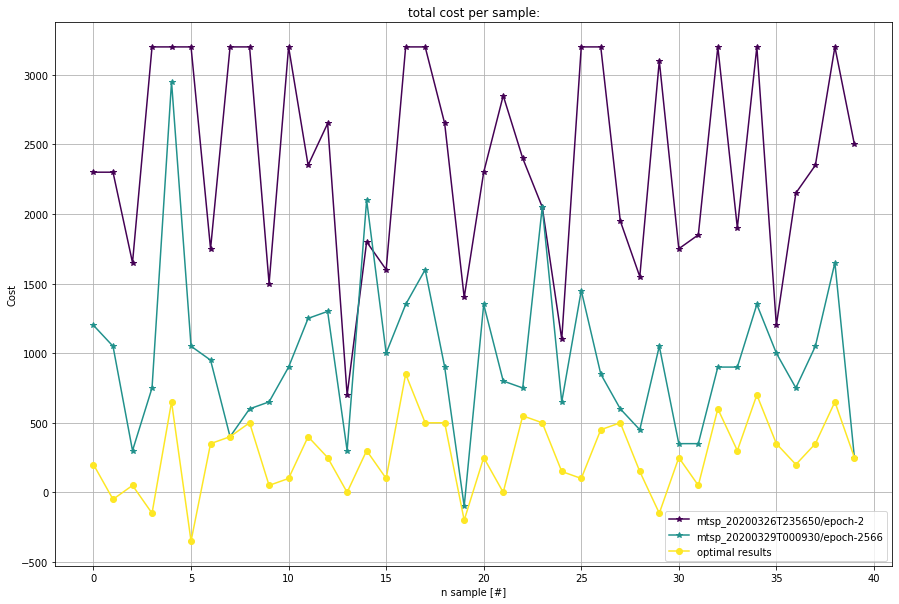

In [11]:
plt.rcParams['figure.figsize'] = [15, 10]
fig_c, ax_c = plt.subplots(1, 1)
for i_n in range(n_networks):
    ax_c.plot(range(n_samples), total_cost_all_nets[i_n, ...], marker='*', color=cmap(i_n), label=network_names[i_n])
ax_c.plot(range(n_samples), opt_cost, marker='o', color=cmap(i_n+1), label='optimal results')
ax_c.set_xlabel('n sample [#]')
ax_c.set_ylabel('Cost')
ax_c.grid()
ax_c.legend(loc='best')
ax_c.set_title('total cost per sample:')

In [15]:
if n_sam›ples<20:
    fig_n, ax_n = plt.subplots(n_splots, 2)
    for i_b in range(n_samples):
        for i_n in range(n_networks):
            x_p = i_b // 2
            y_p = i_b % 2
            ax_n[x_p][y_p].plot(range(total_sim_time), n_events_closed[i_n, i_b, :], marker='*', color=cmap(i_n), label=network_names[i_n])
        ax_n[x_p][y_p].plot(dataOut['time'], dataOut['closedEvents'], marker='o', color=cmap(i_n+1), label='optimal results')
        ax_n[x_p][y_p].set_xlabel('Time')
        ax_n[x_p][y_p].set_ylabel('num events closed')
        ax_n[x_p][y_p].set_title('case - '+ str(i_b), fontsize = 18)
        ax_n[x_p][y_p].grid()
    ax_n[x_p][y_p].legend(loc='best')

In [13]:
dataOut['time']

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [14]:
model.training

False